In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibrationp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes the prepared model calibration featureCollection assets from Module 4, downloads them, sets up LCMS models for Change, Land Cover, and Land Use using scikit-learn, evaluates them, and removes correlated predictor variables.


### Objective

In this tutorial, you learn how to download data from GEE to use be able to set up models using packages from scikit-learn 

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in annual exported training data from Module 4
- Downloading these data to a local location
- Identifying highly correlated predictor variables
- Setting up random forest models for Change, Land Cover, and Land Use and evaluating their accuracy and variable importance

In [5]:
#Module imports
#!python -m pip install geeViz --upgrade

try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p


try:
    import pandas as pd
except:
    !pip install matplotlib
    import pandas as pd

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,cohen_kappa_score
except:
    !pip install -U scikit-learn
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,cohen_kappa_score

import numpy as np
import os
try:
    import seaborn
except:
    !python -m pip install seaborn
    import seaborn
    
ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Done


## Before you begin

### Set your current URL under `workbench_url`
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/`

### Set a folder to use for all exports under `export_path_root` 
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [6]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
export_path_root  = 'projects/rcr-gee/assets/lcms-training'

print('Done')

Done


In [7]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/lcms-292214/assets/R8/PR_USVI/TimeSync/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC'


# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [8]:
Map.proxy_url = workbench_url

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()
# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
# for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimsSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))




LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

In [10]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'BARREN-IMP':12,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
    # print(name_fieldName,code_fieldName.getInfo(),name.getInfo(),code.getInfo())
            
# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

# Take a look at the resulting cross-walked table
print('Converted codes first plot:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())
print('Change class counts:',training_data.aggregate_histogram(reference_field_dict['Change']['field']).getInfo())
print('Land cover class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Cover']['field']).getInfo())
print('Land use class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Use']['field']).getInfo())
print('Done')

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Converted codes first plot: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Forest', 'DOM_LU_Code': 3, 'DOM_SEC_LC': 'BARREN-TRE', 'DOM_SEC_LC_Code': 5}
Change class counts: {'Debris': 6, 'Fire': 3, 'Growth/Recovery': 2501, 'Harvest': 88, 'Hydrology': 67, 'Mechanical': 197, 'Other': 10, 'Spectral Decline': 30, 'Stable': 17544, 'Structural Decline': 2, 'Wind/Ice': 543}
Land cover class counts: {'BARREN-GRA': 106, 'BARREN-IMP': 2096, 'BARREN-SHR': 108, 'BARREN-TRE': 47, 'GRASS': 2346, 'GRASS-SHRU': 877, 'GRASS-TREE': 1111, 'SHRUBS': 832, 'SHRUBS-TRE': 764, 'TREES': 12100, 'WATER': 604}
Land use class counts: {'Agriculture': 636, 'Developed': 3810, 'Forest': 11824, 'Non-forest Wetland': 999, 'Other': 815, 'Rangeland': 2907}
Done


In [11]:
# Now will download the training table to a local location

local_model_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_model_data_folder):os.makedirs(local_model_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

/tmp/lcms-training/local_modeling\timeSync_training_table.csv  already exists


,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,CHANGE_DUR,CP_Code,DOM_LU_Code,DOM_SEC_LC_Code,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
count,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,...,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000
mean,0.0,0.005050,0.099852,0.005145,0.002239,0.0,14.434424,1.446048,3.298604,4.340765,...,26.464866,0.079352,0.005295,0.000475,-0.013667,29.345386,-0.072756,-0.021041,-0.000434,2010.969020
std,0.0,0.070884,0.299810,0.071546,0.047267,0.0,6.677872,1.024257,1.289536,4.450177,...,11.170483,0.040064,0.034007,0.005681,0.029791,10.744572,0.044717,0.042725,0.005656,6.047925
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.006793,-0.210283,-0.070094,-0.483630,1.000000,-0.516985,-0.483630,-0.053737,2000.517822
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,1.000000,3.000000,1.000000,...,17.000000,0.052914,-0.011323,-0.000481,-0.025021,21.000000,-0.096717,-0.039287,-0.001377,2005.906860
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.000000,1.000000,3.000000,1.000000,...,28.000000,0.069325,0.006184,0.000224,-0.012569,37.000000,-0.065846,-0.021936,-0.000674,2011.208252
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,21.000000,1.000000,3.000000,9.000000,...,38.000000,0.095418,0.021533,0.000878,0.000000,38.000000,-0.044558,0.000000,0.000000,2016.167114
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,21.000000,4.000000,6.000000,14.000000,...,38.000000,0.373654,0.300531,0.204653,0.381094,38.000000,0.072465,0.381094,0.226203,2021.411011


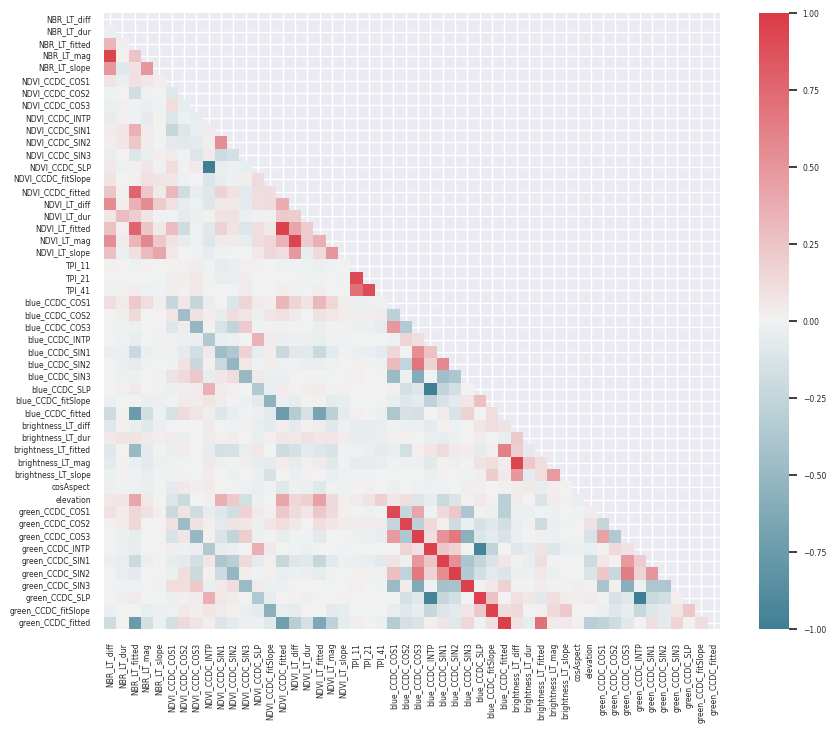

In [189]:
# Once the data are local, we can use the many packages available in Python and even R for data science
# The first step in feature selection (predictor variable selection) 
# LCMS performs is to eliminate extremely correlated predictor variables
# First, we will visualize the correlation of each pair of variables for the first 50 variables
# You can look at all variables, but it is difficult to read the variable name
# The take-home is there are some highly correlated variables that are likely not providing the model much additional information

# Get the correlation matrix for the first 50 variables
corr = training_df[predictor_field_names[:50]].corr()

# Mask out the upper right triangle and the 1:1 diagonal which always has a corr of 1
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

# Plot the matrix
seaborn.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(10, 8))

corrPlot = seaborn.heatmap(corr,
    cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


In [22]:
# In order to remove correlated variables, we will find pairs with a R2 > 0.95 and take the variable with the lowest average R2

# This is the function LCMS uses
# There are many ways of doing this, but this is a simple way that generally gives a good result
def lcms_corr_drop(x,cut = 0.95):
    # Get independent variables from training data table    
    # x = trainingData[indNames]
    indNames = x.columns
    # # reverse order of columns so that Comp features come first for each index so they will be dropped before LT features when correlated
    # x = x[x.columns[::-1]]

    # Find initial correlation of each feature to the others
    corr_matrix = x.corr().abs()
    # Calculate average correlation score of each variable
    corr_score = [corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score, reverse=True)
    sorted_indNames = [element for _, element in sorted_scores]

    # Redo the correlation matrix with the new order of variable names
    x = x[sorted_indNames]
    corr_matrix = x.corr().abs()
    # corr_matrix.to_csv(os.path.join(correlatedVarsDir, run_name+'_CorrelationMatrix.csv'), index = False)

    # Select lower triangle of correlation matrix
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) # numpy error, np.bool is deprecated, changed to bool
    
    # This matrix is ordered in order of correlation score. Use this to check. So we drop in order of correlation score.
    # upper['Average_Scores'] = [pd.concat([upper[varName],upper.loc[varName].transpose()]).mean(skipna=True) for varName in upper.columns]

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop

print('Done')

Done


In [23]:
# Find correlated variables to drop and remove them from the predictor field name list
lcms_to_drop = lcms_corr_drop(training_df[predictor_field_names],cut = 0.95)
print('Correlated variables:',lcms_to_drop)

predictor_field_names_no_corr = [var for var in predictor_field_names if var not in lcms_to_drop]

# Save predictor variables for use in next notebook
all_predictors_csv = os.path.join(local_model_data_folder,'all_predictor_field_names.csv')
o = open(all_predictors_csv,'w')
o.write(','.join(predictor_field_names))
o.close()

no_corr_predictors_csv = os.path.join(local_model_data_folder,'no_corr_predictor_field_names.csv')
o = open(no_corr_predictors_csv,'w')
o.write(','.join(predictor_field_names_no_corr))
o.close()

print('Done')

Correlated variables: ['red_CCDC_fitted', 'green_CCDC_fitted', 'NDVI_CCDC_fitted', 'blue_CCDC_SIN1', 'green_CCDC_COS3', 'red_CCDC_INTP', 'blue_CCDC_SIN2', 'green_CCDC_INTP', 'green_CCDC_SLP', 'blue_CCDC_INTP', 'swir1_CCDC_SLP', 'swir2_CCDC_SLP', 'green_CCDC_SIN3', 'NDVI_CCDC_SLP', 'green_CCDC_fitSlope', 'nir_CCDC_SLP']
Done


In [27]:

# Now we will fit RF models and evaluate them using several methods
# This will help us understand the error structure within the model

# Specify the number of trees and a random seed
# Ideally the number of trees is around 150-250 or so, but it will take a long
# time to run the analysis when it's at 150 or so. 50 is generally enough to get a sense of model accuraccy
nTrees = 5
seed = 999

def fit_rf(product_name,predictor_fields,title_prefix='',var_importance_n = 50):
    product_title = product_name.replace('_',' ')
    
    # Pull out the dependent (y) and independent predictors (X)
    X = training_df[predictor_fields]
    y = training_df[reference_field_dict[product_name]['field']+'_Code']
    
    # Split them into a test and train set for further model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Set up a random forest model
    rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
    
    # First, fit it using all training data
    rf.fit(X,y)
    
    # Get the out-of-bag accuracy 
    # This is generally a good indication of model accuracy
    oob_acc = rf.oob_score_
    print(f'{title_prefix} {product_title} out-of-bag accuracy:',"%.4f" % oob_acc)
    
    # Now let's look at the variable importance
    feature_importances = pd.Series(rf.feature_importances_, index=predictor_fields).sort_values(ascending=True)
    feature_importances.iloc[-var_importance_n:].plot.barh(fontsize=5,title=f'{title_prefix} {product_title} Variable Importance')
    plt.show()
 
    # Now, fit the model using the 80% training subset
    rf.fit(X_train,y_train)
    
    # And then apply it to the 20% test subset
    y_pred = rf.predict(X_test)

    # Find the class names
    class_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    
    # Remove the missing classes in PRUSVI
    if product_name == 'Land_Cover':
        del class_names[1]
        del class_names[4]
        del class_names[-2]
    
    # Get various accuracy metrics
    overall_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Print info about the model
    print(f'{title_prefix} {product_title} report:')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print(f'{title_prefix} {product_title} Overall Accuracy:',"%.4f" % overall_acc)
    print(f'{title_prefix} {product_title} Balanced Accuracy:',"%.4f" % balanced_acc)
    print(f'{title_prefix} {product_title} Kappa:',"%.4f" % kappa)
    
    predictors_by_importance = feature_importances.index.tolist()
    predictors_by_importance.reverse()
    return oob_acc,overall_acc,balanced_acc,kappa,predictors_by_importance
print('Done')

Done


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


All Predictors Change out-of-bag accuracy: 0.8830


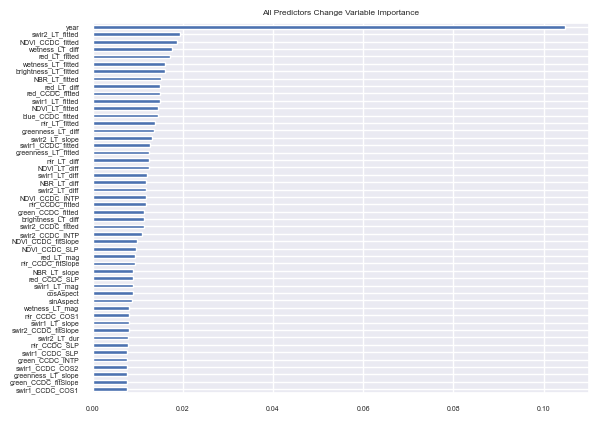

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


All Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.9360    0.9760    0.9556      3539
   Slow Loss     0.2500    1.0000    0.4000         1
   Fast Loss     0.3909    0.2183    0.2801       197
        Gain     0.7367    0.6299    0.6791       462

    accuracy                         0.9024      4199
   macro avg     0.5784    0.7060    0.5787      4199
weighted avg     0.8884    0.9024    0.8934      4199

All Predictors Change Overall Accuracy: 0.9024
All Predictors Change Balanced Accuracy: 0.7060
All Predictors Change Kappa: 0.6059


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non-correlated Predictors Change out-of-bag accuracy: 0.8767


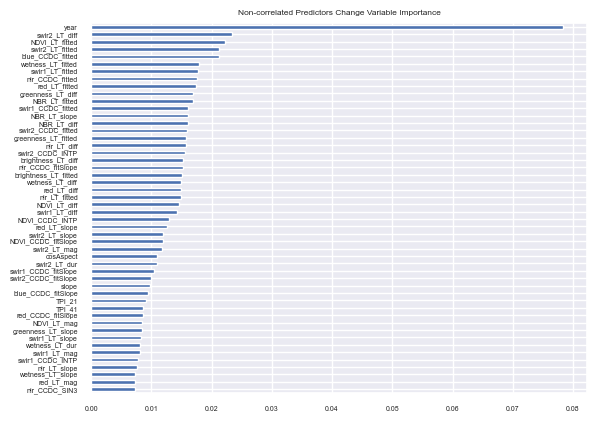

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non-correlated Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.9330    0.9703    0.9513      3532
   Slow Loss     0.6667    0.4000    0.5000         5
   Fast Loss     0.2386    0.1257    0.1647       167
        Gain     0.7402    0.6505    0.6925       495

    accuracy                         0.8983      4199
   macro avg     0.6446    0.5366    0.5771      4199
weighted avg     0.8824    0.8983    0.8890      4199

Non-correlated Predictors Change Overall Accuracy: 0.8983
Non-correlated Predictors Change Balanced Accuracy: 0.5366
Non-correlated Predictors Change Kappa: 0.5951


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Top 30 Var Imp Change out-of-bag accuracy: 0.8800


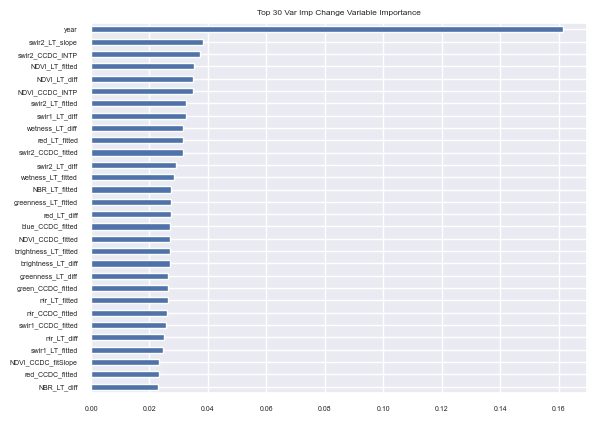

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.9229    0.9713    0.9465      3524
   Slow Loss     0.6000    0.3333    0.4286         9
   Fast Loss     0.6306    0.3646    0.4620       192
        Gain     0.7834    0.6181    0.6910       474

    accuracy                         0.9024      4199
   macro avg     0.7342    0.5718    0.6320      4199
weighted avg     0.8931    0.9024    0.8944      4199

Top 30 Var Imp Change Overall Accuracy: 0.9024
Top 30 Var Imp Change Balanced Accuracy: 0.5718
Top 30 Var Imp Change Kappa: 0.6054


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non Corr Top 30 Var Imp Change out-of-bag accuracy: 0.8763


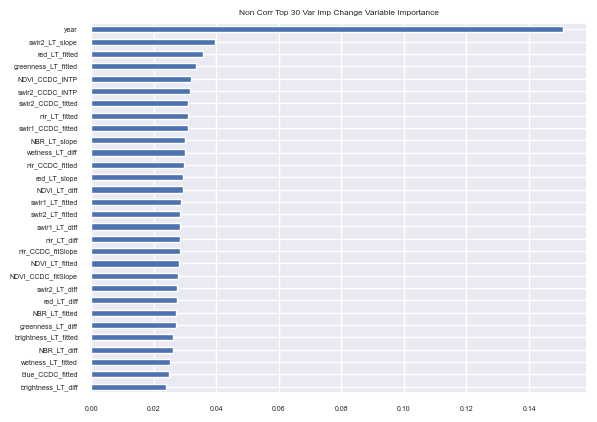

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non Corr Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.9224    0.9787    0.9497      3475
   Slow Loss     1.0000    0.1667    0.2857         6
   Fast Loss     0.6772    0.4778    0.5603       180
        Gain     0.8385    0.5985    0.6985       538

    accuracy                         0.9074      4199
   macro avg     0.8595    0.5554    0.6235      4199
weighted avg     0.9013    0.9074    0.8999      4199

Non Corr Top 30 Var Imp Change Overall Accuracy: 0.9074
Non Corr Top 30 Var Imp Change Balanced Accuracy: 0.5554
Non Corr Top 30 Var Imp Change Kappa: 0.6441


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


All Predictors Land Cover out-of-bag accuracy: 0.9085


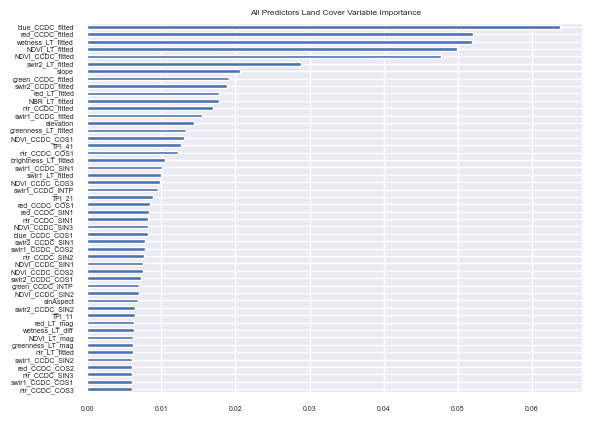

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


All Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9799    0.9929    0.9863      2400
          Shrubs & Trees Mix     0.8832    0.9308    0.9064       130
 Grass/Forb/Herb & Trees Mix     0.9400    0.8545    0.8952       220
          Barren & Trees Mix     0.6000    0.3333    0.4286         9
                      Shrubs     0.9277    0.9277    0.9277       166
Grass/Forb/Herb & Shrubs Mix     0.9195    0.9195    0.9195       174
         Barren & Shrubs Mix     0.9048    0.9048    0.9048        21
             Grass/Forb/Herb     0.9677    0.9562    0.9619       502
Barren & Grass/Forb/Herb Mix     0.7857    0.6875    0.7333        16
        Barren or Impervious     0.9815    0.9748    0.9781       436
                       Water     1.0000    0.9680    0.9837       125

                    accuracy                         0.9681      4199
                   macro avg     0.8991    0.8591    0

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non-correlated Predictors Land Cover out-of-bag accuracy: 0.9092


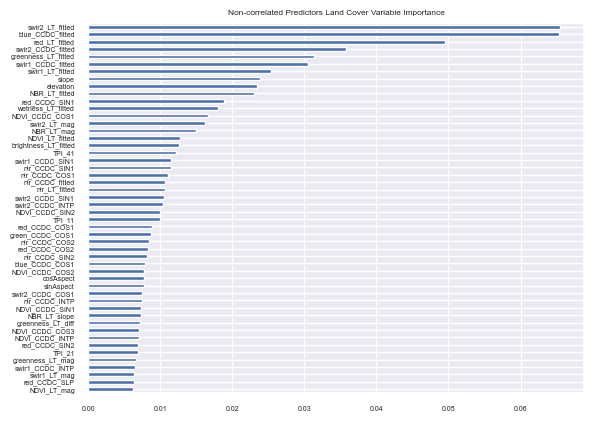

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non-correlated Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9725    0.9916    0.9820      2392
          Shrubs & Trees Mix     0.8676    0.8252    0.8459       143
 Grass/Forb/Herb & Trees Mix     0.9452    0.8554    0.8980       242
          Barren & Trees Mix     0.7273    0.7273    0.7273        11
                      Shrubs     0.9837    0.9235    0.9526       196
Grass/Forb/Herb & Shrubs Mix     0.8889    0.9302    0.9091       172
         Barren & Shrubs Mix     0.9412    0.7619    0.8421        21
             Grass/Forb/Herb     0.9457    0.9638    0.9547       470
Barren & Grass/Forb/Herb Mix     0.9412    0.6957    0.8000        23
        Barren or Impervious     0.9852    0.9708    0.9779       411
                       Water     0.9732    0.9237    0.9478       118

                    accuracy                         0.9619      4199
                   macro avg     0.9247    

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Top 30 Var Imp Land Cover out-of-bag accuracy: 0.9088


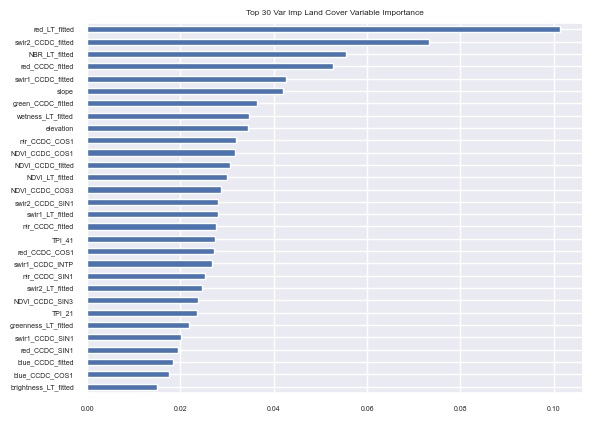

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9716    0.9917    0.9816      2415
          Shrubs & Trees Mix     0.9281    0.8165    0.8687       158
 Grass/Forb/Herb & Trees Mix     0.9028    0.8478    0.8744       230
          Barren & Trees Mix     0.2222    0.4000    0.2857         5
                      Shrubs     0.9571    0.9070    0.9313       172
Grass/Forb/Herb & Shrubs Mix     0.9251    0.9058    0.9153       191
         Barren & Shrubs Mix     0.8000    0.8889    0.8421         9
             Grass/Forb/Herb     0.9700    0.9537    0.9618       475
Barren & Grass/Forb/Herb Mix     0.8667    0.7647    0.8125        17
        Barren or Impervious     0.9756    0.9779    0.9767       408
                       Water     0.9832    0.9832    0.9832       119

                    accuracy                         0.9621      4199
                   macro avg     0.8638    0.8579    0

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non Corr Top 30 Var Imp Land Cover out-of-bag accuracy: 0.9095


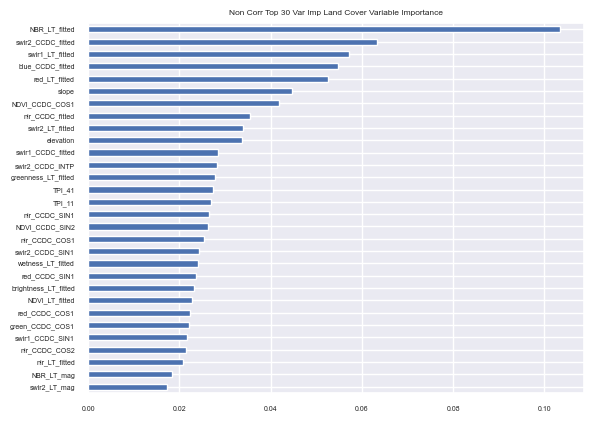

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non Corr Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9790    0.9917    0.9853      2398
          Shrubs & Trees Mix     0.9241    0.8690    0.8957       168
 Grass/Forb/Herb & Trees Mix     0.8861    0.8824    0.8842       238
          Barren & Trees Mix     0.6250    0.5556    0.5882         9
                      Shrubs     0.9325    0.9325    0.9325       163
Grass/Forb/Herb & Shrubs Mix     0.9000    0.8743    0.8870       175
         Barren & Shrubs Mix     0.9444    0.8947    0.9189        19
             Grass/Forb/Herb     0.9591    0.9389    0.9489       475
Barren & Grass/Forb/Herb Mix     0.7647    0.6500    0.7027        20
        Barren or Impervious     0.9756    0.9756    0.9756       410
                       Water     0.9839    0.9839    0.9839       124

                    accuracy                         0.9626      4199
                   macro avg     0.8977    0.

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


All Predictors Land Use out-of-bag accuracy: 0.8746


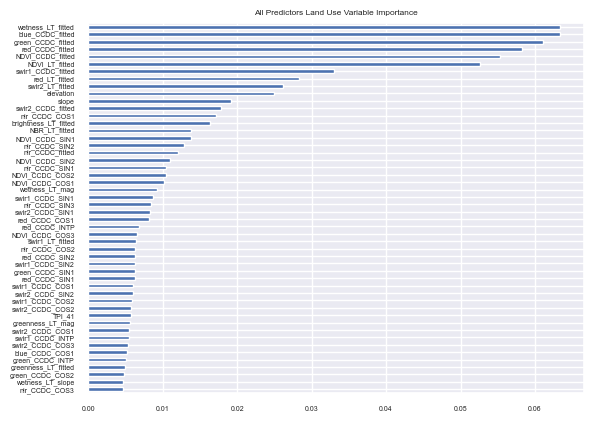

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


All Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.9784    0.9855    0.9819       138
           Developed     0.9785    0.9973    0.9878       731
              Forest     0.9938    0.9942    0.9940      2405
  Non-Forest Wetland     0.9843    0.9691    0.9766       194
               Other     0.9937    0.9691    0.9813       162
Rangeland or Pasture     0.9857    0.9701    0.9779       569

            accuracy                         0.9890      4199
           macro avg     0.9857    0.9809    0.9832      4199
        weighted avg     0.9891    0.9890    0.9890      4199

All Predictors Land Use Overall Accuracy: 0.9890
All Predictors Land Use Balanced Accuracy: 0.9809
All Predictors Land Use Kappa: 0.9823


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non-correlated Predictors Land Use out-of-bag accuracy: 0.8733


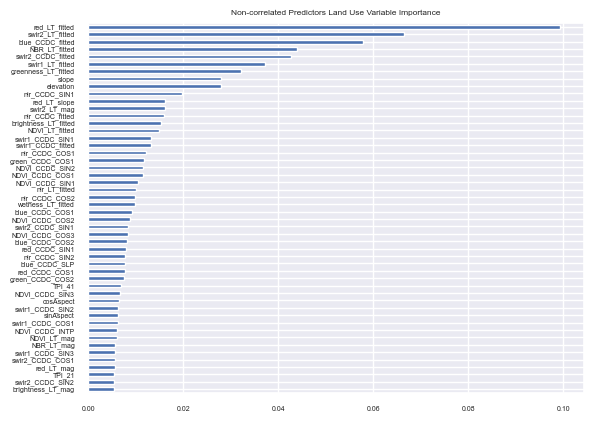

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non-correlated Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.9652    0.9823    0.9737       113
           Developed     0.9873    0.9974    0.9924       781
              Forest     0.9924    0.9932    0.9928      2370
  Non-Forest Wetland     1.0000    0.9709    0.9853       172
               Other     0.9936    0.9750    0.9842       160
Rangeland or Pasture     0.9833    0.9768    0.9800       603

            accuracy                         0.9898      4199
           macro avg     0.9870    0.9826    0.9847      4199
        weighted avg     0.9898    0.9898    0.9898      4199

Non-correlated Predictors Land Use Overall Accuracy: 0.9898
Non-correlated Predictors Land Use Balanced Accuracy: 0.9826
Non-correlated Predictors Land Use Kappa: 0.9835


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Top 30 Var Imp Land Use out-of-bag accuracy: 0.8737


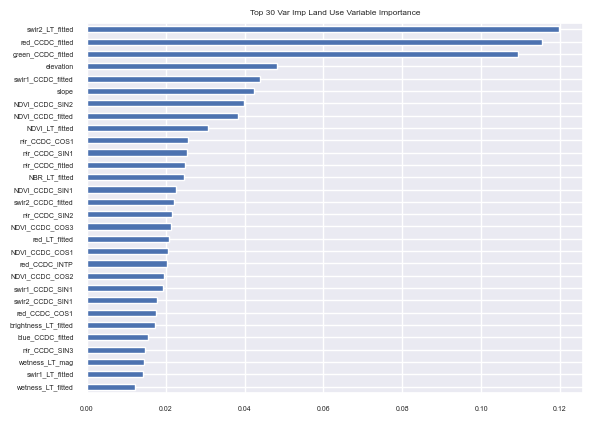

c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.9917    0.9836    0.9877       122
           Developed     0.9815    0.9854    0.9834       753
              Forest     0.9930    0.9926    0.9928      2424
  Non-Forest Wetland     0.9778    0.9944    0.9860       177
               Other     1.0000    0.9873    0.9936       157
Rangeland or Pasture     0.9770    0.9735    0.9752       566

            accuracy                         0.9883      4199
           macro avg     0.9868    0.9861    0.9864      4199
        weighted avg     0.9883    0.9883    0.9883      4199

Top 30 Var Imp Land Use Overall Accuracy: 0.9883
Top 30 Var Imp Land Use Balanced Accuracy: 0.9861
Top 30 Var Imp Land Use Kappa: 0.9809


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Non Corr Top 30 Var Imp Land Use out-of-bag accuracy: 0.8769


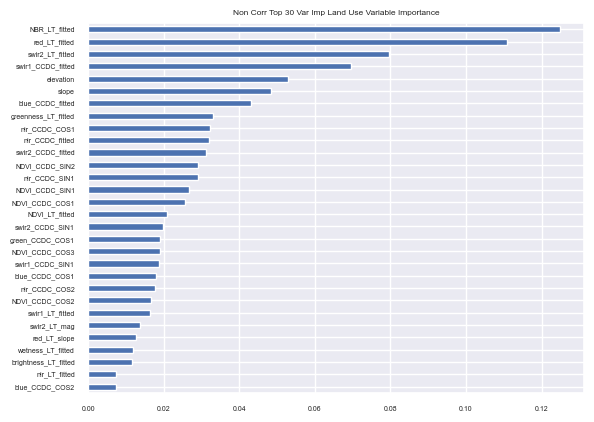

Non Corr Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.9855    0.9927    0.9891       137
           Developed     0.9846    0.9974    0.9910       771
              Forest     0.9920    0.9945    0.9933      2372
  Non-Forest Wetland     0.9849    0.9800    0.9825       200
               Other     1.0000    0.9863    0.9931       146
Rangeland or Pasture     0.9839    0.9599    0.9717       573

            accuracy                         0.9893      4199
           macro avg     0.9885    0.9851    0.9868      4199
        weighted avg     0.9893    0.9893    0.9892      4199

Non Corr Top 30 Var Imp Land Use Overall Accuracy: 0.9893
Non Corr Top 30 Var Imp Land Use Balanced Accuracy: 0.9851
Non Corr Top 30 Var Imp Land Use Kappa: 0.9828
Done


c:\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [29]:
# Now evaluate models for each LCMS product with various sets of predictor variables
# and create a summary table
product_names = ['Change','Land_Cover','Land_Use']
acc_table = []
for product_name in product_names:
    
    # First fit a model using all predictors
    all_model_info = list(fit_rf(product_name,predictor_field_names,'All Predictors'))
    all_model_info.insert(0,'All Predictors')
    all_model_info.insert(0,product_name)
    acc_table.append(all_model_info)
    
    # Then fit a model using the variables with < 0.95 r-squared
    non_corr_model_info = list(fit_rf(product_name,predictor_field_names_no_corr,'Non-correlated Predictors'))
    non_corr_model_info.insert(0,'Non-correlated Predictors')
    non_corr_model_info.insert(0,product_name)
    acc_table.append(non_corr_model_info)
    
    # Next take only the top 30 predictors regardless of co-variance 
    all_top30_model_info = list(fit_rf(product_name,all_model_info[-1][:30],'Top 30 Var Imp'))
    all_top30_model_info.insert(0,'All Predictors Top 30')
    all_top30_model_info.insert(0,product_name)
    acc_table.append(all_top30_model_info)
    
    # Then take the top 30 with < 0.95 r-squared
    non_corr_top30_model_info = list(fit_rf(product_name,non_corr_model_info[-1][:30],'Non Corr Top 30 Var Imp'))
    non_corr_top30_model_info.insert(0,'Non-correlated Predictors Top 30')
    non_corr_top30_model_info.insert(0,product_name)
    acc_table.append(non_corr_top30_model_info)

print('Done')

In [30]:
model_options_df = pd.DataFrame(acc_table,columns = ['Product Name','Model Name','OOB Acc','Overall Acc','Balanced Acc','Kappa','Var Imp'])
display(model_options_df)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_model_options_table.csv')
model_options_df.to_csv(model_options_csv_filename,index=False)
    
print('Done')

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
0,Change,All Predictors,0.882997,0.902358,0.706032,0.605911,"[year, swir2_LT_fitted, NDVI_CCDC_fitted, wetn..."
1,Change,Non-correlated Predictors,0.876709,0.898309,0.536631,0.595131,"[year, swir2_LT_diff, NDVI_LT_fitted, swir2_LT..."
2,Change,All Predictors Top 30,0.880044,0.902358,0.571850,0.605362,"[year, swir2_LT_slope, swir2_CCDC_INTP, NDVI_L..."
3,Change,Non-correlated Predictors Top 30,0.876280,0.907359,0.555416,0.644123,"[year, swir2_LT_slope, red_LT_fitted, greennes..."
4,Land_Cover,All Predictors,0.908485,0.968088,0.859093,0.949858,"[blue_CCDC_fitted, red_CCDC_fitted, wetness_LT..."
5,Land_Cover,Non-correlated Predictors,0.909152,0.961896,0.869916,0.940293,"[swir2_LT_fitted, blue_CCDC_fitted, red_LT_fit..."
6,Land_Cover,All Predictors Top 30,0.908770,0.962134,0.857923,0.940068,"[red_LT_fitted, swir2_CCDC_fitted, NBR_LT_fitt..."
7,Land_Cover,Non-correlated Predictors Top 30,0.909533,0.962610,0.868053,0.941466,"[NBR_LT_fitted, swir2_CCDC_fitted, swir1_LT_fi..."
8,Land_Use,All Predictors,0.874565,0.989045,0.980880,0.982280,"[wetness_LT_fitted, blue_CCDC_fitted, green_CC..."
9,Land_Use,Non-correlated Predictors,0.873327,0.989759,0.982617,0.983534,"[red_LT_fitted, swir2_LT_fitted, blue_CCDC_fit..."


Done


In [31]:
os.listdir(local_model_data_folder)

['all_predictor_field_names.csv',
 'LCMS_model_options_table.csv',
 'no_corr_predictor_field_names.csv',
 'timeSync_training_table.csv']

Getting model info for All Predictors Change
All Predictors Change OOB Accuracy: 0.9221094754894955


,Stable,Slow Loss,Fast Loss,Gain,Producers Accuracy (1 - omission error)
Stable,17542,0,0,2,99
Slow Loss,1,31,0,0,96
Fast Loss,57,0,852,5,93
Gain,20,0,0,2481,99
Consumers Accuracy (1 - commission error),99,100,100,99,99


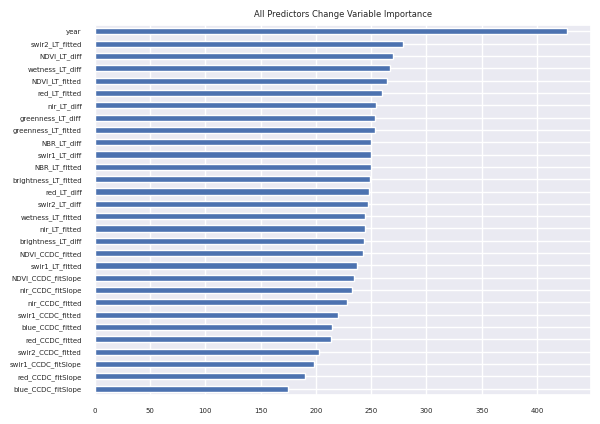

AttributeError: 'FeatureCollection' object has no attribute 'confusionMatrix'

In [179]:

# Not let's train similar models inside GEE to see the similarities and differences

# Set some parameters
top_n_variables = 30 # Take this number of variables into the final model
nTrees = 50

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    plt.show()
# Function to take GEE confusionMatrix object and make a Pandas dataframe from it
def formatConfusionMatrix(confusionMatrix,code_names):
    # Only make one call to GEE for the confusion matrix info
    cm_info = ee.Dictionary({
        'accuracy':confusionMatrix.accuracy(),
        'consumersAccuracy':confusionMatrix.consumersAccuracy(),
        'producersAccuracy':confusionMatrix.producersAccuracy(),
        'confusionMatrix':confusionMatrix
    }).getInfo()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(cm_info['accuracy']*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in cm_info['consumersAccuracy'][0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in cm_info['producersAccuracy'][1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = cm_info['confusionMatrix']
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    formatConfusionMatrix(confusionMatrix,code_names)
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model info
    code_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    importance = getModelInfo(rf, code_names,f'All Predictors {product_title}')
    
    

    training = training_data.filter("random < 0.8")
    holdout = training_data.filter("random >= 0.8")
    rf2 = rf.train(training, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    validation = holdout.classify(rf2,'predicted')
    # # print(validation.first().getInfo())
    confusionMatrix = validation.confusionMatrix(reference_field_dict[product_name]['field']+'_Code', "predicted")
    formatConfusionMatrix(confusionMatrix,code_names)
    # print(errorMatrix.getInfo())

    
    # predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    # Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')
training_data = training_data.randomColumn(seed=seed)
for product in ['Land_Cover','Land_Use','Change'][-1:]:
    fit_rf(product)
# print(training_data.size().getInfo())
# Notice the out-of-bag accuracy is roughly the same as in scikit-learn random forest

# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
# Map.turnOnInspector()
# Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

In [64]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=10,scoring = 'balanced_accuracy')
scores
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

NameError: name 'rf' is not defined